In [616]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Parsing FASTA File

In [617]:
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as file:
        content = file.read().strip()

    # Split the content by the '>' character, which marks the start of a new sequence
    entries = content.split('>')
    
    for entry in entries:
        if entry:
            # Split each entry into lines
            lines = entry.split('\n')
            # The first line is the header
            header = lines[0].strip()
            # The remaining lines are the sequence
            sequence = ''.join(lines[1:]).strip()
            # Append the header and sequence to the list as a tuple
            sequences.append((header, sequence.upper()))
    
    return sequences

In [618]:
# load sequence/FASTA data
sequences = parse_fasta('/Users/sham/Desktop/Dr. Hanson Research/class_material_analysis/Saccharomycodes ludwigii/data/ncbi_dataset/ncbi_dataset/data/GCF_020623625.1/GCF_020623625.1_UHD_SCDLUD_16_genomic.fna')
# load GTF data
GTF_df = pd.read_csv('/Users/sham/Desktop/Dr. Hanson Research/class_material_analysis/Saccharomycodes ludwigii/data/ncbi_dataset/ncbi_dataset/data/GCF_020623625.1/genomic.gtf', sep='\t', comment='#', header=None)

## Number of Chromosomes

In [619]:
print("Number of Chromosoems: ", len(sequences))

Number of Chromosoems:  8


## Define Functions

In [620]:
def complement_seq(seq):
    seq_list = list(seq)

    for i in range(len(seq_list)):
        if seq_list[i] == 'A':
            seq_list[i] = 'T'
        elif seq_list[i] == 'T':
            seq_list[i] = 'A'
        elif seq_list[i] == 'G':
            seq_list[i] = 'C'
        else:
            seq_list[i] = 'G'
    return ''.join(seq_list)

# reset indexing
def reset_df(df):
    out_df = df.reset_index()
    out_df = out_df.drop('index', axis=1)
    return out_df

def filter_irregular_gene(df):
    to_drop = []
    for i in range(len(df)):
        if (df.iloc[i,8][21] == 't' or df.iloc[i,8][21] == 'r'):
            to_drop.append(i)
    df = df.drop(to_drop)
    df = reset_df(df)

    print('to drop: ', to_drop)

    return df

## Get CDS data only

In [621]:
# Get gene and CDS data only
GTF_gene_and_cds = GTF_df[GTF_df[2].isin(['CDS'])]
GTF_gene_and_cds = reset_df(GTF_gene_and_cds)

# get chromosome names
GTF_gene_and_cds.iloc[:,0].unique()

array(['NC_060200.1', 'NC_060201.1', 'NC_060202.1', 'NC_060203.1',
       'NC_060204.1', 'NC_060205.1', 'NC_060206.1', 'NW_025763369.1'],
      dtype=object)

## Seperate chromosome-wise data

In [622]:
# separate by chromosome and filter irregular gene
# filter_irregular_gene() doesn't do anything for S. ludiwigii - was made for Y. lipolytoca
GTF_chr1_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060200.1']))
GTF_chr2_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060201.1']))
GTF_chr3_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060202.1']))
GTF_chr4_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060203.1']))
GTF_chr5_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060204.1']))
GTF_chr6_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060205.1']))
GTF_chr7_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NC_060206.1']))
GTF_chr8_gene_cds = filter_irregular_gene(reset_df(GTF_gene_and_cds[GTF_gene_and_cds[0] == 'NW_025763369.1']))

to drop:  []
to drop:  []
to drop:  []
to drop:  []
to drop:  []
to drop:  []
to drop:  []
to drop:  []


## Functoins to calculate window-wise GC3 percentage

In [623]:
def depricated_get_cds_gene_idx(seq, gtf):
    
    # list of indexes list that have the strand info and all the cds indexes of a gene
    # example: [['+', 1], ['-', 3, 4, 5], ['-', 7, 8, 9, 10], ['+', 12], ['+', 14], ...]
    gene_cds_idx = []
    ind_idx = ['x']
    for i in range(1, len(gtf)):
        if (gtf.iloc[i,2] != 'gene'):
            ind_idx.append(i)
            ind_idx[0] = gtf.iloc[i,6]
        elif (gtf.iloc[i,2] == 'gene'):
            gene_cds_idx.append(ind_idx)
            ind_idx = ['x']
    gene_cds_idx.append(ind_idx)

    print(gene_cds_idx)
    print(len(gene_cds_idx))
    
    gene_cds_sequences = []

    tot=0
    miss=0

    for cds_range in gene_cds_idx:
        seq_str = ''
        frame_skip = 0
        if cds_range[0] == '+':
            for idx in cds_range[1:]:
                frame_skip = int(gtf.iloc[idx,7])
                seq_str += seq[gtf.iloc[idx,3]-1+frame_skip : gtf.iloc[idx,4]]
                frame_skip = 0
            gene_cds_sequences.append(seq_str)
            tot+=1
        elif cds_range[0] == '-':
            for idx in cds_range[1:]:
                frame_skip = int(gtf.iloc[idx,7])
                seq_str += complement_seq(seq[gtf.iloc[idx,3]-1 : gtf.iloc[idx,4]-frame_skip])[::-1]
                frame_skip = 0
            gene_cds_sequences.append(seq_str)
            tot+=1
        else:
            miss+=1
            print(cds_range[0])

    print("tot",tot)
    print("miss", miss)
    
    return gene_cds_sequences


def calc_gc3_pct(gene_seqs, window):
    pct_arr = []
    for seq in gene_seqs:
        codon3_ct = 0
        gc3_ct = 0
        for i in range(2,len(seq),3):
            if (seq[i] == 'G' or seq[i] == 'C'):
                gc3_ct += 1
            codon3_ct += 1
        pct_arr.append((gc3_ct / codon3_ct) * 100)

    print(pct_arr)
    
    window_pct_arr = []
    for i in range(len(pct_arr)-window+1):
        window_range = pct_arr[i:i + window]
        window_avg = sum(window_range) / window
        window_pct_arr.append(window_avg)

    return window_pct_arr

In [624]:
def get_cds_gene_idx(seq, gtf):
    gene_cds_idx = []
    
    # Create a list of tuples [(strand, [indices])]
    for i in range(len(gtf)):
        strand = gtf.iloc[i, 6]  # Strand info (+/-)
        index = i  # Row index in GTF
        gene_cds_idx.append((strand, [index]))  # Store as tuple

    gene_cds_sequences = []

    for cds_range in gene_cds_idx:
        seq_str = ''
        frame_skip = 0
        strand = cds_range[0]
        indices = cds_range[1]  # List of indices

        if strand == '+':  # Forward strand
            for idx in indices:
                if isinstance(idx, int):  # Ensure idx is an integer
                    frame_skip = int(gtf.iloc[idx, 7])
                    seq_str += seq[gtf.iloc[idx, 3] - 1 + frame_skip : gtf.iloc[idx, 4]]
                    frame_skip = 0
            gene_cds_sequences.append(seq_str)

        elif strand == '-':  # Reverse strand
            for idx in indices:
                if isinstance(idx, int):  # Ensure idx is an integer
                    frame_skip = int(gtf.iloc[idx, 7])
                    seq_str += complement_seq(seq[gtf.iloc[idx, 3] - 1 : gtf.iloc[idx, 4] - frame_skip])[::-1]
                    frame_skip = 0
            gene_cds_sequences.append(seq_str)

        else:
            print("Unexpected strand value:", strand)


    return gene_cds_sequences


## Calculate GC3 pct for window size of 15 CDSs

In [625]:
chr1_gene_cds_seqs = get_cds_gene_idx(sequences[0][1], GTF_chr1_gene_cds)
chr2_gene_cds_seqs = get_cds_gene_idx(sequences[1][1], GTF_chr2_gene_cds)
chr3_gene_cds_seqs = get_cds_gene_idx(sequences[2][1], GTF_chr3_gene_cds)
chr4_gene_cds_seqs = get_cds_gene_idx(sequences[3][1], GTF_chr4_gene_cds)
chr5_gene_cds_seqs = get_cds_gene_idx(sequences[4][1], GTF_chr5_gene_cds)
chr6_gene_cds_seqs = get_cds_gene_idx(sequences[5][1], GTF_chr6_gene_cds)
chr7_gene_cds_seqs = get_cds_gene_idx(sequences[6][1], GTF_chr7_gene_cds)
# chr8_gene_cds_seqs = get_cds_gene_idx(sequences[7][1], GTF_chr8_gene_cds)

win_size = 15

chr1_gc3_pcts = calc_gc3_pct(chr1_gene_cds_seqs, win_size)
chr2_gc3_pcts = calc_gc3_pct(chr2_gene_cds_seqs, win_size)
chr3_gc3_pcts = calc_gc3_pct(chr3_gene_cds_seqs, win_size)
chr4_gc3_pcts = calc_gc3_pct(chr4_gene_cds_seqs, win_size)
chr5_gc3_pcts = calc_gc3_pct(chr5_gene_cds_seqs, win_size)
chr6_gc3_pcts = calc_gc3_pct(chr6_gene_cds_seqs, win_size)
chr7_gc3_pcts = calc_gc3_pct(chr7_gene_cds_seqs, win_size)
# chr8_gc3_pcts = calc_gc3_pct(chr8_gene_cds_seqs, win_size)

[39.366515837104075, 25.639739086803814, 29.67032967032967, 31.951219512195124, 29.84293193717277, 23.25581395348837, 30.80444735120994, 27.573062261753496, 23.4192037470726, 21.11801242236025, 21.893491124260358, 30.730296456977584, 27.6657060518732, 30.0, 23.61111111111111, 23.872679045092838, 29.366602687140116, 22.47191011235955, 29.15951972555746, 22.55639097744361, 25.0, 33.33333333333333, 27.9445727482679, 27.653997378768018, 22.6628895184136, 28.22695035460993, 27.692307692307693, 23.456790123456788, 26.666666666666668, 27.365728900255753, 26.06741573033708, 30.845771144278604, 25.105485232067508, 25.724217844727693, 20.930232558139537, 25.048169556840076, 24.666666666666668, 26.36986301369863, 20.869565217391305, 27.601809954751133, 28.703703703703702, 26.96629213483146, 30.16304347826087, 20.125786163522015, 24.45328031809145, 27.388535031847134, 27.824019024970276, 29.227761485826004, 24.574669187145556, 28.216704288939056, 28.520286396181383, 29.72972972972973, 29.303278688

## GenerateBedFile

In [626]:
def create_BED(gtf, pcts, win_size):
    out_df = pd.DataFrame(columns=['chrom', 'start', 'end', 'pct'])
    for i in range(len(gtf)-win_size+1):
        row = pd.DataFrame({'chrom': [gtf.iloc[i][0]], 
                            'start': [gtf.iloc[i][3]], 
                            'end': [gtf.iloc[i+win_size-1][4]], 
                            'pct': [round(pcts[i], 4)]})
        out_df = pd.concat([out_df, row], ignore_index=True)
    
    return out_df


In [627]:
bed1 = create_BED(GTF_chr1_gene_cds, chr1_gc3_pcts, win_size)
bed2 = create_BED(GTF_chr2_gene_cds, chr2_gc3_pcts, win_size)
bed3 = create_BED(GTF_chr3_gene_cds, chr3_gc3_pcts, win_size)
bed4 = create_BED(GTF_chr4_gene_cds, chr4_gc3_pcts, win_size)
bed5 = create_BED(GTF_chr5_gene_cds, chr5_gc3_pcts, win_size)
bed6 = create_BED(GTF_chr6_gene_cds, chr6_gc3_pcts, win_size)
bed7 = create_BED(GTF_chr7_gene_cds, chr7_gc3_pcts, win_size)
# bed8 = create_BED(GTF_chr8_gene_cds, chr8_gc3_pcts, win_size)

all_bed = pd.concat([bed1, bed2, bed3, bed4, bed5, bed6, bed7], ignore_index=True)

all_bed.to_csv('/Users/sham/Desktop/Dr. Hanson Research/class_material_analysis/Saccharomycodes ludwigii/S ludwigii.bed', sep='\t', header=False, index=False)

/var/folders/1k/jj40mz3j3zj2w9gsgg7xpylm0000gn/T/ipykernel_43848/2134393739.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df = pd.concat([out_df, row], ignore_index=True)
/var/folders/1k/jj40mz3j3zj2w9gsgg7xpylm0000gn/T/ipykernel_43848/2134393739.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  out_df = pd.concat([out_df, row], ignore_index=True)
/var/folders/1k/jj40mz3j3zj2w9gsgg7xpylm0000gn/T/ipykernel_43848/2134393739.py:8: FutureWarning: The behavior of DataFrame concatenation w

In [628]:
all_bed

,chrom,start,end,pct
0,NC_060200.1,7855,59492,27.7695
1,NC_060200.1,15107,61780,26.7365
2,NC_060200.1,21858,63541,26.9850
3,NC_060200.1,29333,66471,26.5051
4,NC_060200.1,34089,69497,26.3190
...,...,...,...,...
5097,NC_060206.1,745994,783000,29.0984
5098,NC_060206.1,750824,783899,28.8551
5099,NC_060206.1,752157,787386,29.1275
5100,NC_060206.1,753456,790828,29.2834


## Plot Chromosome-wise GC3 pcts

In [629]:
import matplotlib.pyplot as plt

def plot_gc3_percentage(chr_gc3_pcts, chr_name):
    # Create figure
    plt.figure(figsize=(8, 4))
    plt.plot(chr_gc3_pcts, label="GC3 Percentage")

    # Get the index of the minimum GC3 percentage
    min_index = chr_gc3_pcts.index(min(chr_gc3_pcts))
    min_value = min(chr_gc3_pcts)

    # Title with the location of minimum GC3 percentage
    plt.title(f'{chr_name}; window size: 15')

    # Setting the y-axis limits and ticks
    plt.ylim(22, 35)
    yticks = [25, 30, 35]
    plt.yticks(yticks)

    # Adding horizontal lines at y-tick positions
    for y in yticks:
        plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

    # Adding x-ticks every 50 intervals
    xticks = range(0, len(chr_gc3_pcts), 50)
    plt.xticks(xticks, rotation=90)

    # Adding vertical lines at each x-tick
    for x in xticks:
        plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)

    plt.xlabel('Window #')
    plt.ylabel('GC3 Percentage')

    # Adding a horizontal line 60 units long at the index of the minimum value
    # plt.hlines(y=min_value, xmin=max(min_index - win_size/2, 0), xmax=min_index + win_size/2, 
    #            color='red', linewidth=2, label='Window Considered')

    # Adding a marker at the minimum GC3 percentage
    # plt.scatter(min_index, min_value-.2, color='blue', zorder=1, label='Minimum GC3')

    # Adding a legend
    plt.legend()

    # Display the plot
    plt.show()

# Example usage:
# plot_gc3_percentage(chr1_gc3_pcts)


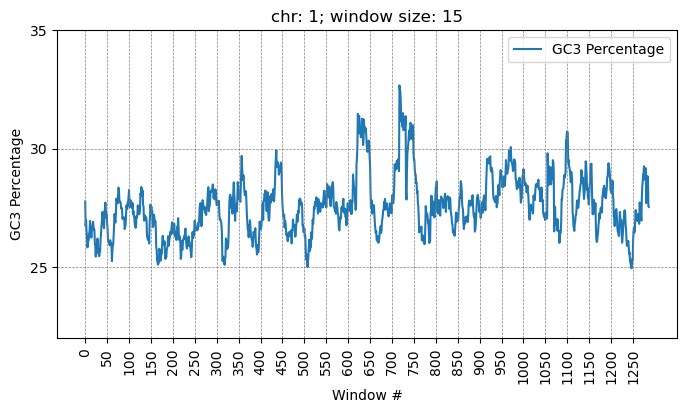

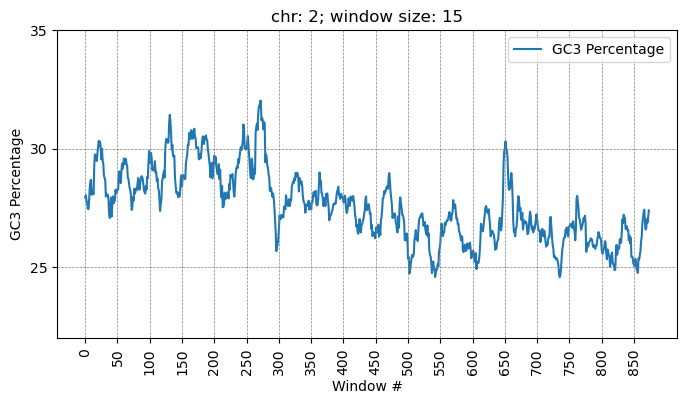

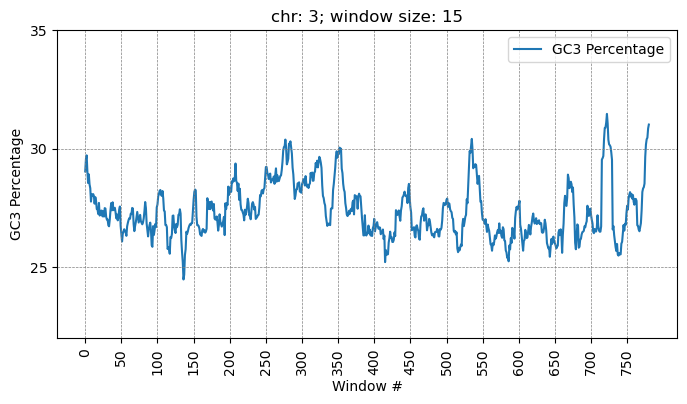

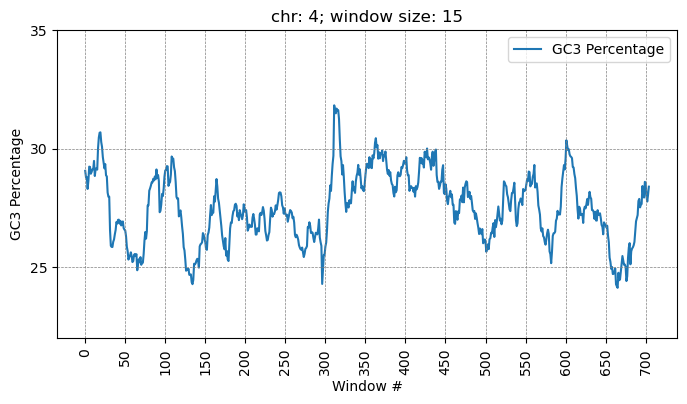

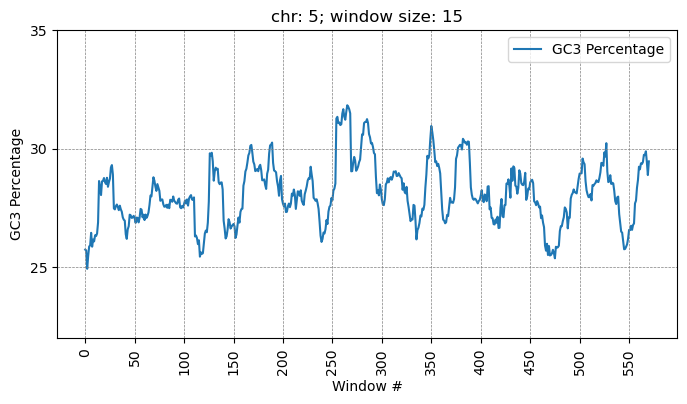

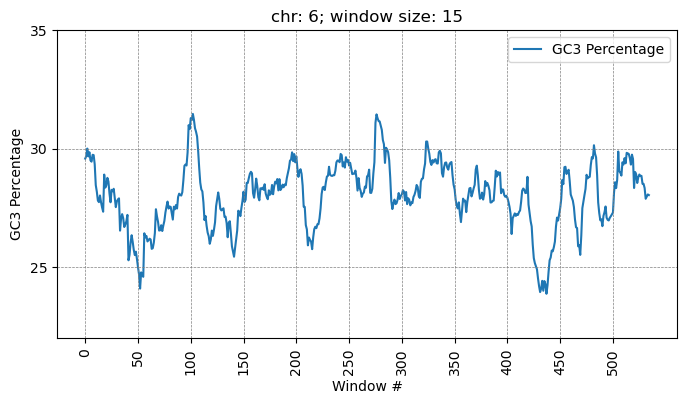

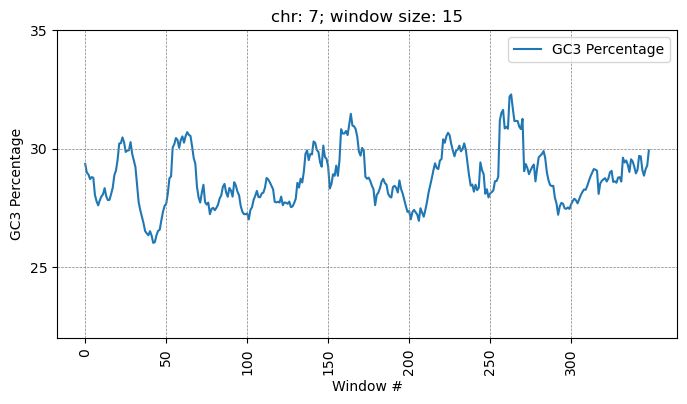

In [630]:
plot_gc3_percentage(chr1_gc3_pcts, "chr: 1")
plot_gc3_percentage(chr2_gc3_pcts, "chr: 2")
plot_gc3_percentage(chr3_gc3_pcts, "chr: 3")
plot_gc3_percentage(chr4_gc3_pcts, "chr: 4")
plot_gc3_percentage(chr5_gc3_pcts, "chr: 5")
plot_gc3_percentage(chr6_gc3_pcts, "chr: 6")
plot_gc3_percentage(chr7_gc3_pcts, "chr: 7")
# plot_gc3_percentage(chr8_gc3_pcts, win_size)

## plot whole-genome GC3 pcts

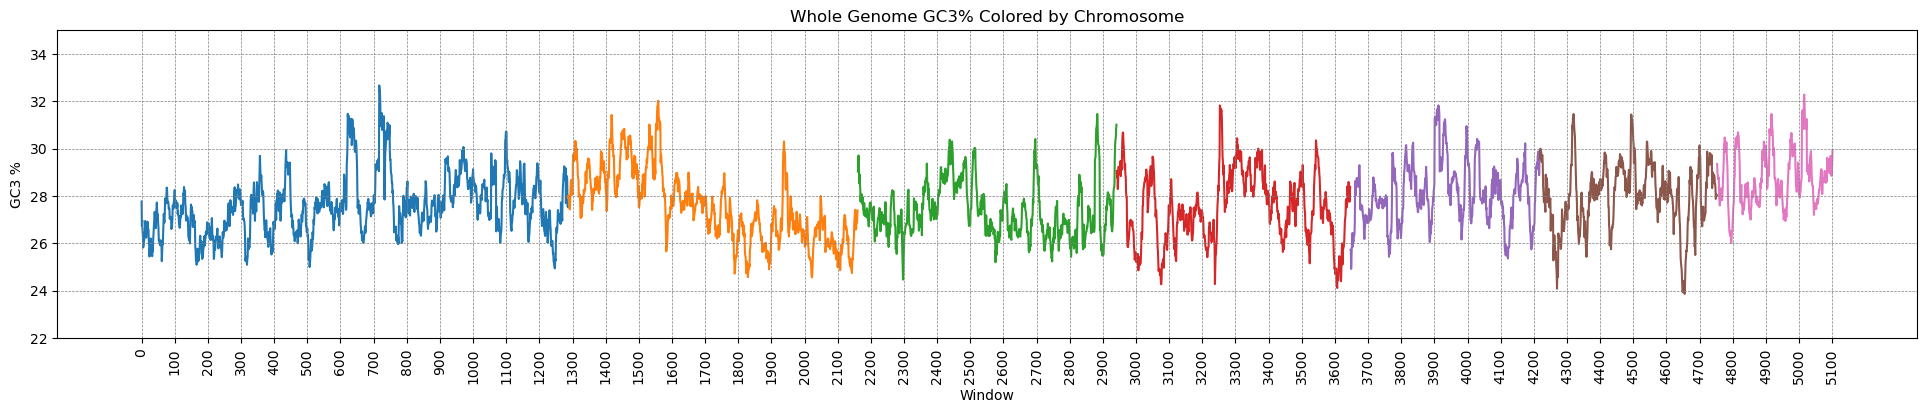

In [631]:
plt.figure(figsize=(24, 4))

sns.lineplot(x=all_bed.index, y=all_bed['pct'], hue=all_bed['chrom'], palette='tab10', legend=None)

plt.ylim(22, 35)
yticks = [22, 24, 26, 28, 30, 32, 34]
plt.yticks(yticks)
for y in yticks:
    plt.axhline(y=y, color='gray', linestyle='--', linewidth=0.5)

xticks = range(0, 5200, 100)
plt.xticks(xticks, rotation=90)
for x in xticks:
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)


plt.xlabel('Window')
plt.ylabel('GC3 %')
plt.title('Whole Genome GC3% Colored by Chromosome')
plt.show()


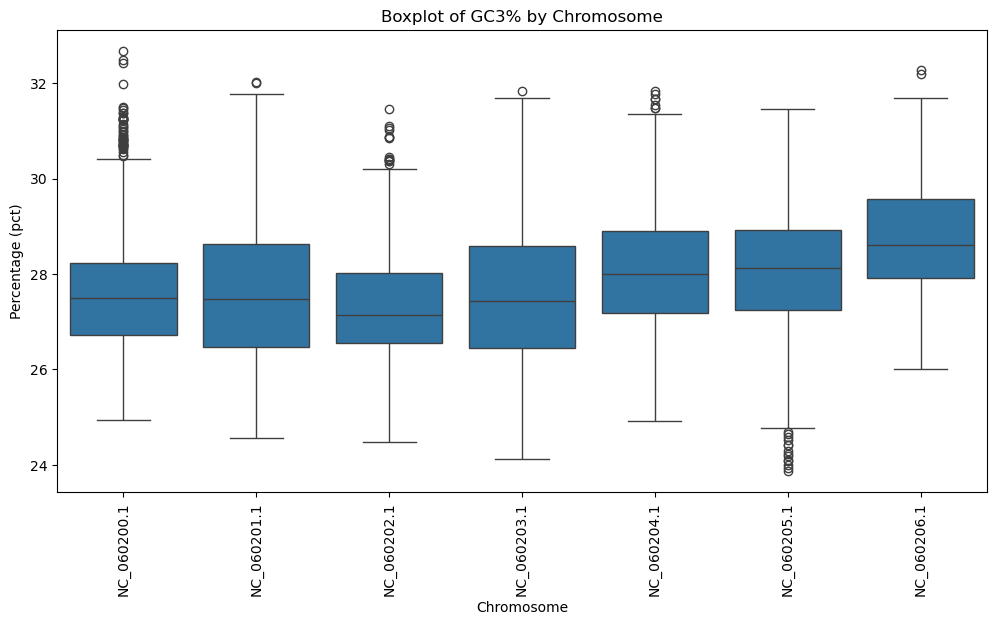

In [632]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='chrom', y='pct', data=all_bed)
plt.xticks(rotation=90)
plt.xlabel('Chromosome')
plt.ylabel('Percentage (pct)')
plt.title('Boxplot of GC3% by Chromosome')
plt.show()

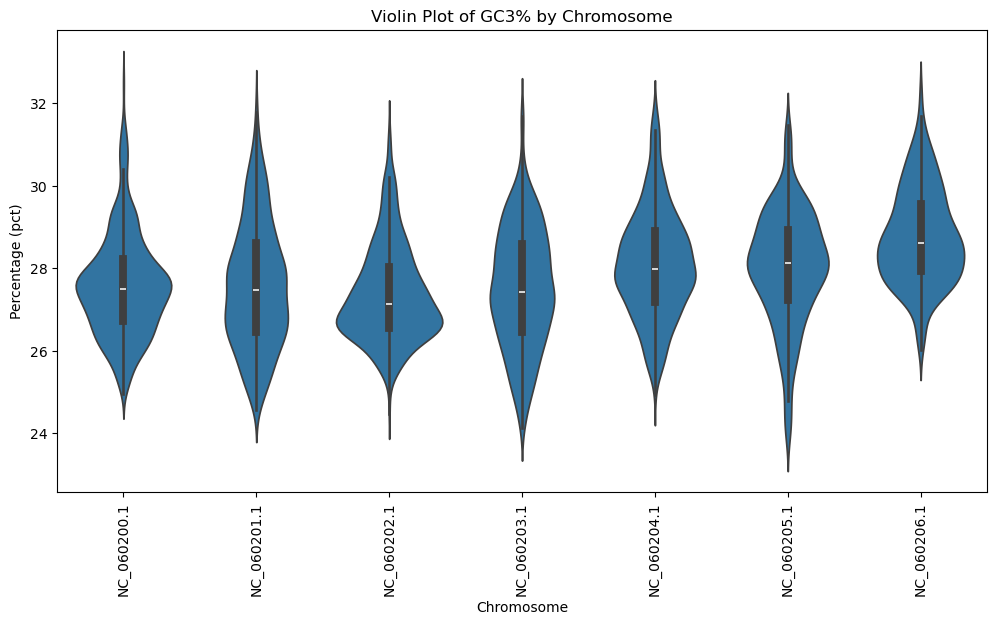

In [633]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named all_bed
plt.figure(figsize=(12, 6))
sns.violinplot(x='chrom', y='pct', data=all_bed)
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.xlabel('Chromosome')
plt.ylabel('Percentage (pct)')
plt.title('Violin Plot of GC3% by Chromosome')
plt.show()


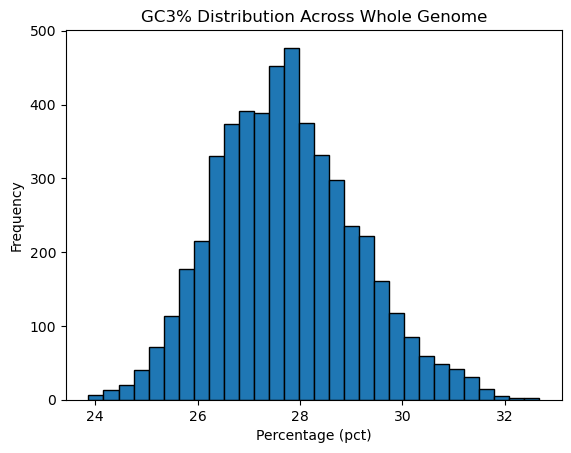

In [634]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df
plt.hist(all_bed['pct'], bins=30, edgecolor='black')  # You can adjust the number of bins
plt.xlabel('Percentage (pct)')
plt.ylabel('Frequency')
plt.title('GC3% Distribution Across Whole Genome')
plt.show()


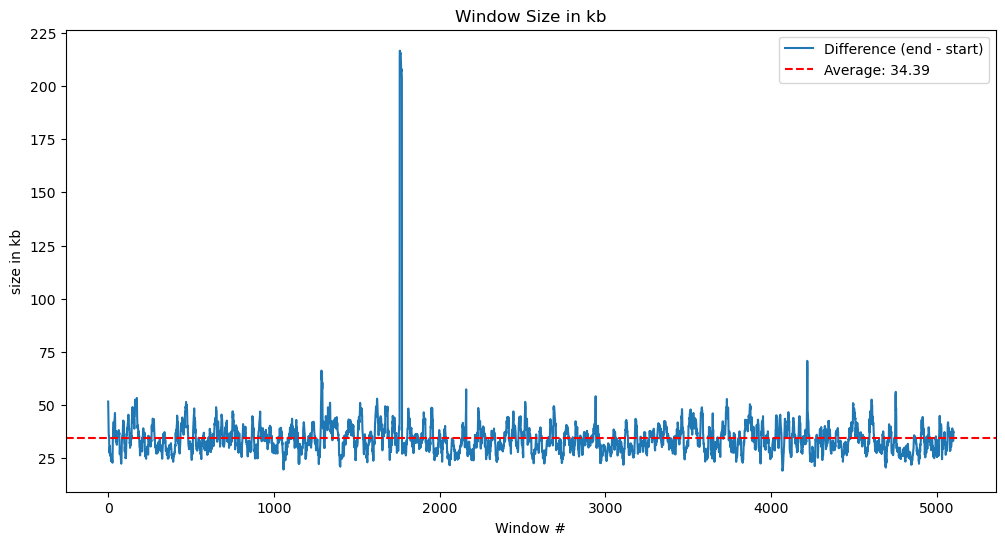

In [635]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named all_bed

# Create a new column 'diff' representing the difference between 'end' and 'start'
all_bed['diff'] = (all_bed['end'] - all_bed['start']) / 1000

# Calculate the average of the 'diff' column
avg_diff = all_bed['diff'].mean()

# Plot the 'diff' column
plt.figure(figsize=(12, 6))
plt.plot(all_bed['diff'], label='Difference (end - start)')

# Plot the average line
plt.axhline(y=avg_diff, color='red', linestyle='--', label=f'Average: {avg_diff:.2f}')

# Add labels and title
plt.xlabel('Window #')
plt.ylabel('size in kb')
plt.title('Window Size in kb')
plt.legend()  # Add legend to show the average line

plt.show()


# The code below is irrelevant

## Gene only dataframes

In [636]:
GTF_gene_only = GTF_df[GTF_df[2].isin(['gene'])]
GTF_gene_only = reset_df(GTF_gene_only)

# separate by chromosome and filter irregular gene
# filter_irregular_gene() doesn't do anything for K. phaffi - was made for Y. lipolytoca
GTF_chr1_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060200.1']))
GTF_chr2_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060201.1']))
GTF_chr3_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060202.1']))
GTF_chr4_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060203.1']))
GTF_chr5_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060204.1']))
GTF_chr6_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060205.1']))
GTF_chr7_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NC_060206.1']))
# GTF_chr8_gene = (reset_df(GTF_gene_only[GTF_gene_only[0] == 'NW_025763369.1']))

## Largest intergenic region within the local window

In [637]:
def get_n_largest_ig_region(df, n_window, window_size):
    largest_regions = [(-1, 0) for i in range(window_size)]

    adjusment = 0
    if (n_window + window_size -1) - len(df) > 0:
        print('here')
        adjusment = (n_window + window_size -1) - len(df) + 1

    for i in range(n_window - window_size +1 , n_window + window_size -1 - adjusment):
        for idx, r in enumerate(largest_regions):
            if (df.iloc[i+1,3] - df.iloc[i,4]) > r[0]:
                largest_regions[idx] = ((df.iloc[i+1,3] - df.iloc[i,4]), i)
                largest_regions = sorted(largest_regions, key=lambda x: x[0])
                break
    return largest_regions


In [638]:
scan_range = 60

largest_IG_chr1 = get_n_largest_ig_region(GTF_chr1_gene,chr1_gc3_pcts.index(min(chr1_gc3_pcts)), scan_range)
largest_IG_chr2 = get_n_largest_ig_region(GTF_chr2_gene,chr2_gc3_pcts.index(min(chr2_gc3_pcts)), scan_range)
largest_IG_chr3 = get_n_largest_ig_region(GTF_chr3_gene,chr3_gc3_pcts.index(min(chr3_gc3_pcts)), scan_range)
largest_IG_chr4 = get_n_largest_ig_region(GTF_chr4_gene,chr4_gc3_pcts.index(min(chr4_gc3_pcts)), scan_range)
largest_IG_chr5 = get_n_largest_ig_region(GTF_chr5_gene,chr5_gc3_pcts.index(min(chr5_gc3_pcts)), scan_range)
largest_IG_chr6 = get_n_largest_ig_region(GTF_chr6_gene,chr6_gc3_pcts.index(min(chr6_gc3_pcts)), scan_range)
largest_IG_chr7 = get_n_largest_ig_region(GTF_chr7_gene,chr7_gc3_pcts.index(min(chr7_gc3_pcts)), scan_range)
# largest_IG_chr8 = get_n_largest_ig_region(GTF_chr8_gene,chr8_gc3_pcts.index(min(chr8_gc3_pcts)), scan_range)

## Largest IG across the whole chromosomes

In [639]:
def whole_chr_get_n_largest_ig_region(df, window_size):
    largest_regions = [(-1, 0) for i in range(window_size)]
    # cadidates = 0
    for i in range(len(df)-1):
        # cadidates += 1
        for idx, r in enumerate(largest_regions):
            if (df.iloc[i+1,3] - df.iloc[i,4]) > r[0]:
                largest_regions[idx] = ((df.iloc[i+1,3] - df.iloc[i,4]), i)
                largest_regions = sorted(largest_regions, key=lambda x: x[0])
                break
    return largest_regions

In [640]:
whole_largest_IG_chr1 = whole_chr_get_n_largest_ig_region(GTF_chr1_gene, win_size)
whole_largest_IG_chr2 = whole_chr_get_n_largest_ig_region(GTF_chr2_gene, win_size)
whole_largest_IG_chr3 = whole_chr_get_n_largest_ig_region(GTF_chr3_gene, win_size)
whole_largest_IG_chr4 = whole_chr_get_n_largest_ig_region(GTF_chr4_gene, win_size)
whole_largest_IG_chr5 = whole_chr_get_n_largest_ig_region(GTF_chr5_gene, win_size)
whole_largest_IG_chr6 = whole_chr_get_n_largest_ig_region(GTF_chr6_gene, win_size)
whole_largest_IG_chr7 = whole_chr_get_n_largest_ig_region(GTF_chr7_gene, win_size)
whole_largest_IG_chr7 = whole_chr_get_n_largest_ig_region(GTF_chr7_gene, win_size)

In [641]:
print(largest_IG_chr1[-5:])
print(whole_largest_IG_chr1[-5:])

[(1807, 1251), (2267, 1188), (2530, 1208), (2855, 1268), (3033, 1288)]
[(4296, 811), (5605, 977), (6074, 680), (6584, 0), (6623, 1319)]


In [642]:
print(largest_IG_chr2[-5:])
print(whole_largest_IG_chr2[-5:])

[(2129, 709), (2425, 762), (2757, 701), (2771, 757), (3009, 697)]
[(6294, 917), (6527, 0), (6553, 3), (10762, 4), (104314, 513)]


In [643]:
print(largest_IG_chr3[-5:])
print(whole_largest_IG_chr3[-5:])

[(1537, 130), (2174, 81), (2354, 138), (2869, 121), (5436, 161)]
[(4150, 2), (5436, 161), (5686, 809), (6376, 342), (6505, 0)]


In [644]:
print(largest_IG_chr4[-5:])
print(whole_largest_IG_chr4[-5:])

[(2335, 626), (2730, 645), (3018, 666), (4398, 632), (6047, 668)]
[(5314, 376), (5481, 740), (6047, 668), (6443, 490), (8203, 0)]


In [645]:
print(largest_IG_chr5[-5:])
print(whole_largest_IG_chr5[-5:])

[(3198, 56), (5839, 2), (7800, -3), (7885, -2), (8766, 1)]
[(5564, 284), (5839, 2), (7800, 609), (7885, 610), (8766, 1)]


In [646]:
print(largest_IG_chr6[-5:])
print(whole_largest_IG_chr6[-5:])

[(1461, 385), (1647, 493), (1986, 411), (2898, 391), (4204, 410)]
[(4204, 410), (4534, 7), (5844, 0), (6320, 553), (8741, 552)]


In [647]:
print(largest_IG_chr7[-5:])
print(whole_largest_IG_chr7[-5:])

[(3188, -4), (3389, -3), (3399, 2), (3502, -11), (5915, 1)]
[(3502, 358), (4040, 181), (5245, 307), (5255, 180), (5915, 1)]
